In [1]:
!pip install emoji
!pip install NRCLex
!pip install seaborn
!pip install nltk
!pip install contractions
!pip install unidecode
!pip install tensorflow_text tensorflow_hub
!pip install vaderSentiment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Import library
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from bs4 import BeautifulSoup
import contractions
import re
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/FYP/fake_news_dataset/final_combined_dataset.tsv'
df = pd.read_csv(path, sep='\t', usecols=['title', 'domain', 'num_comments', 'score', 'upvote_ratio', 'emotion_group', 'real', 'fake'])
df.describe()

,num_comments,score,upvote_ratio,emotion_group,real,fake
count,328710.000000,328710.000000,328710.000000,328710.000000,328710.000000,328710.000000
mean,27.740035,696.485662,0.857447,0.351100,0.355669,0.644331
std,164.420455,4220.889452,0.107756,0.283677,0.478716,0.478716
min,1.000000,1.000000,0.500000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,0.790000,0.000000,0.000000,0.000000
50%,4.000000,22.000000,0.880000,0.500000,0.000000,1.000000
75%,10.000000,75.000000,0.940000,0.500000,1.000000,1.000000
max,10783.000000,137179.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
def display_all(df):
  with pd.option_context("display.max_rows", 1000):
    with pd.option_context("display.max_columns", 1000):
      display(df)

display_all(df)

,domain,num_comments,score,title,upvote_ratio,emotion_group,real,fake
0,i.imgur.com,2.0,12,My Walgreens offbrand Mucinex was engraved wit...,0.84,0.5,0,1
1,i.redd.it,2.0,119,This concerned sink with a tiny hat,0.99,0.5,1,0
2,i.imgur.com,26.0,250,PsBattle: Puppy taking in the view,0.95,0.5,0,1
3,i.redd.it,2.0,13,I found a face in my sheet music too!,0.84,0.0,1,0
4,independent.ie,7.0,6,Bride and groom exchange vows after fatal shoo...,0.64,0.5,0,1
...,...,...,...,...,...,...,...,...
328705,i.redd.it,1.0,4,Those paint free spots on this picture frame I...,0.83,0.5,0,1
328706,prod.images.vikings.clubs.nflcdn.com,1.0,5,Sexy Waldo and Friends,0.86,0.0,0,1
328707,i.redd.it,8.0,6,Blur-the death of a party,0.81,0.0,1,0
328708,i.redd.it,28.0,1560,PsBattle: This cat on the sidewalk,0.97,0.0,0,1


In [5]:
print("Dataset size:", len(df))

Dataset size: 328710


In [6]:
# Check for total numbers of words in dataset
print("Total number of words in the dataset:", df['title'].apply(lambda x: len(x.split(' '))).sum())

Total number of words in the dataset: 3275616


## Data Visualization

In [7]:
# Count the number of real and fake news articles
real_count = df['real'].sum()
fake_count = df['fake'].sum()
print("Number of real news articles:", real_count)
print("Number of fake news articles:", fake_count)

Number of real news articles: 116912
Number of fake news articles: 211798


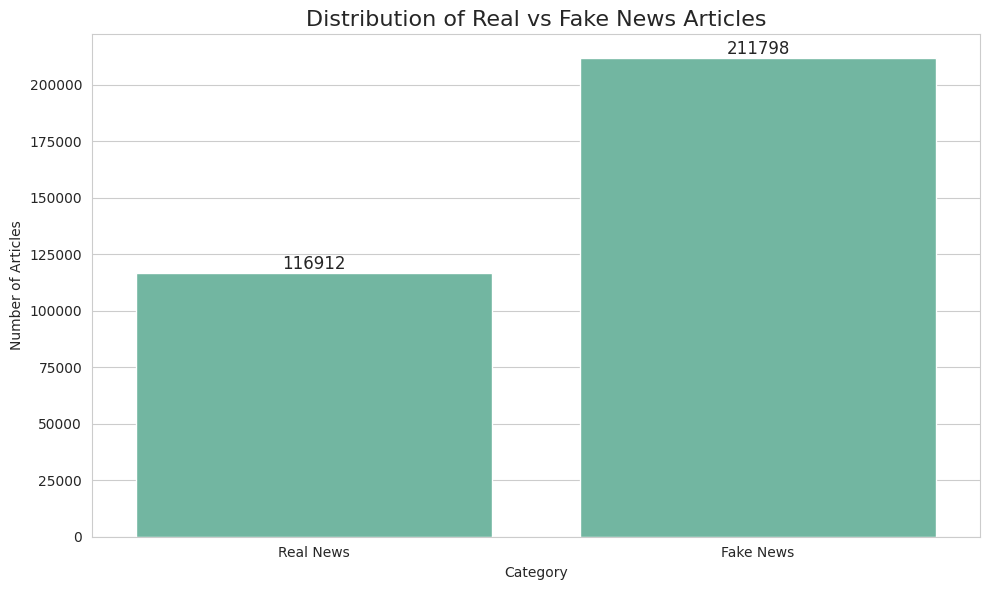

In [8]:
# Create a datadrame with the counts
data = pd.DataFrame({'Category': ['Real News', 'Fake News'], 'Count': [real_count, fake_count]})

# Set the style and color palette
sns.set_style('whitegrid')
sns.set_palette("Set2")

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Category', y='Count', data=data)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Distribution of Real vs Fake News Articles',  fontsize=16)

# Add value labels on top of each bar
for i, v in enumerate(data['Count']):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
# Function to categorize emotion groups
def categorize_emotion(value):
  if value == 0:
    return 'Expectation'
  elif value == 0.5:
    return 'Neutral'
  else:
    return 'Novelty'

# Apply the categorization
df['emotion_category'] = df['emotion_group'].apply(categorize_emotion)

# Calculate the distribution
emotion_dist = df.groupby('emotion_category').agg({
    'real': 'sum',
    'fake': 'sum'
}).reset_index()

# Calculate percentages based on total real and fake news
total_real = emotion_dist['real'].sum()
total_fake = emotion_dist['fake'].sum()

emotion_dist['real_pct'] = emotion_dist['real'] / total_real * 100
emotion_dist['fake_pct'] = emotion_dist['fake'] / total_fake * 100

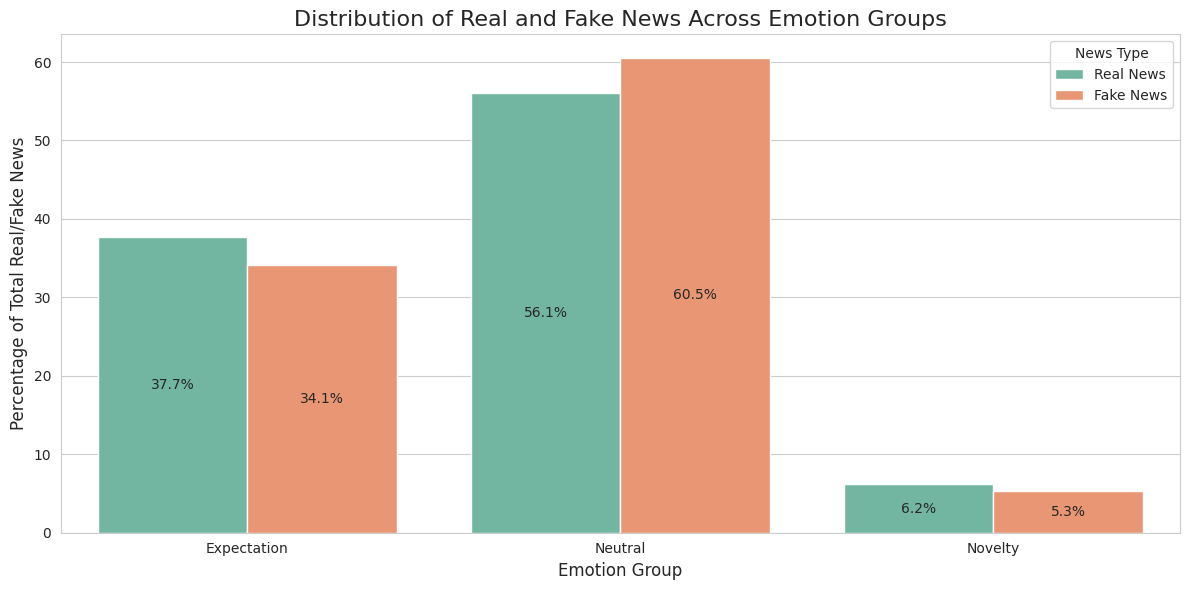

  emotion_category   real    fake   real_pct   fake_pct
0      Expectation  44101   72324  37.721534  34.147631
1          Neutral  65602  128148  56.112290  60.504821
2          Novelty   7209   11326   6.166176   5.347548
Total Real News: 116912
Total Fake News: 211798


In [10]:
# Prepare data for plotting
plot_data = pd.melt(emotion_dist,
                    id_vars=['emotion_category'],
                    value_vars=['real_pct', 'fake_pct'],
                    var_name='news_type',
                    value_name='percentage')

plot_data['news_type'] = plot_data['news_type'].map({'real_pct': 'Real News', 'fake_pct': 'Fake News'})

# Create the grouped bar chart
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.set_palette("Set2")

ax = sns.barplot(x='emotion_category', y='percentage', hue='news_type', data=plot_data)

# Customize the chart
plt.title('Distribution of Real and Fake News Across Emotion Groups', fontsize=16)
plt.xlabel('Emotion Group', fontsize=12)
plt.ylabel('Percentage of Total Real/Fake News', fontsize=12)
plt.legend(title='News Type', loc='upper right', fontsize=10)

# Add percentage labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

# Show the plot
plt.tight_layout()
plt.show()

# Print the exact percentages and counts
print(emotion_dist[['emotion_category', 'real', 'fake', 'real_pct', 'fake_pct']])
print(f"Total Real News: {total_real}")
print(f"Total Fake News: {total_fake}")

## Text Preprocessing

In [11]:
# Lower case characters
def lower_case(text):
  return text.lower()

In [12]:
df['title'] = df['title'].apply(lower_case)

In [13]:
def remove_newlines_tabs(text):
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    return Formatted_text

In [14]:
df['title'] = df['title'].apply(remove_newlines_tabs)

In [15]:
def remove_html(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    return text

In [16]:
df['title'] = df['title'].apply(remove_html)

<ipython-input-15-ca2ebf912f89>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)


In [17]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

In [18]:
df['title'] = df['title'].apply(expand_contractions)

In [19]:
def remove_urls(text):
    pattern = re.compile(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?')
    text = re.sub(pattern, "", text)
    return text

In [20]:
df['title'] = df['title'].apply(remove_urls)

In [21]:
def handle_accents(text):
    text = unidecode(text)
    return text

In [22]:
df['title'] = df['title'].apply(handle_accents)

In [23]:
def remove_special_characters(text):
  return re.sub(r'[^a-zA-Z0-9\s]', '', text)

In [24]:
df['title'] = df['title'].apply(remove_special_characters)

In [25]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

In [26]:
df['title'] = df['title'].apply(remove_stopwords)

In [27]:
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text).strip()
    return text

In [28]:
df['title'] = df['title'].apply(remove_extra_spaces)

In [29]:
def lemmatize_text(text):
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text

In [30]:
df['title'] = df['title'].apply(lemmatize_text)
df["title"].sample(5, random_state=42)

208930    school vending machine design white cheddar po...
9278         psbattle guy panda suit caring real baby panda
324598                           peach ate looked like bird
298005                   psbattle burrowing owl spot camera
239811                                lot actor enough prop
Name: title, dtype: object

In [31]:
def generate_wordcloud(text):
    # Combine all preprocessed titles into a single string
    text = ' '.join(text)

    # Create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Frequent Words in Titles')
    plt.show()


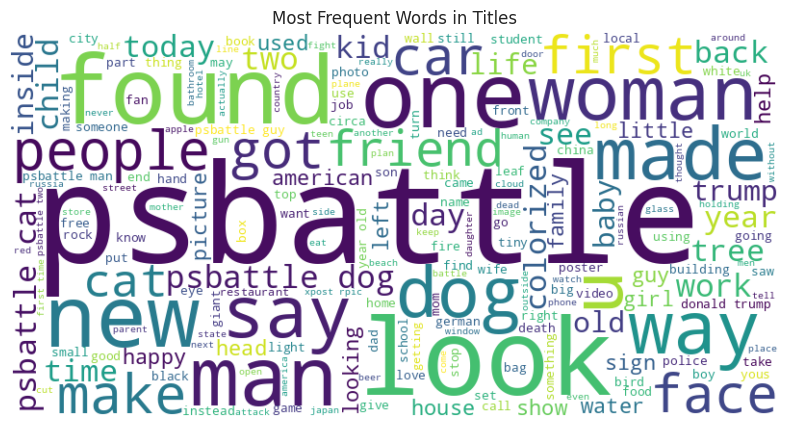

In [32]:
generate_wordcloud(df['title'])

## Sentiment Analysis Unit

### TextBlob

In [33]:
# TextBlob sentiment analysis
def textblob_sentiment_analyzer(review):
    sentiment = TextBlob(review)
    score = sentiment.sentiment.polarity
    if score > 0:
        category = "Positive"
    elif score < 0:
        category = "Negative"
    else:
        category = "Neutral"
    return category, score

### VADER

In [34]:
# VADER sentiment analysis
def vader_sentiment_analyzer(review):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(review)
    compound_score = sentiment_scores['compound']

    if compound_score >= 0.05:
        category = "Positive"
        normalized_score = 1
    elif compound_score <= -0.05:
        category = "Negative"
        normalized_score = -1
    else:
        category = "Neutral"
        normalized_score = 0

    return category, normalized_score, compound_score

In [35]:
# Apply sentiment analyses
df[['textblob_category', 'textblob_score']] = df['title'].apply(textblob_sentiment_analyzer).apply(pd.Series)
df[['vader_category', 'vader_score', 'sentiment_score']] = df['title'].apply(vader_sentiment_analyzer).apply(pd.Series)

## Data visualization for Sentiment Category

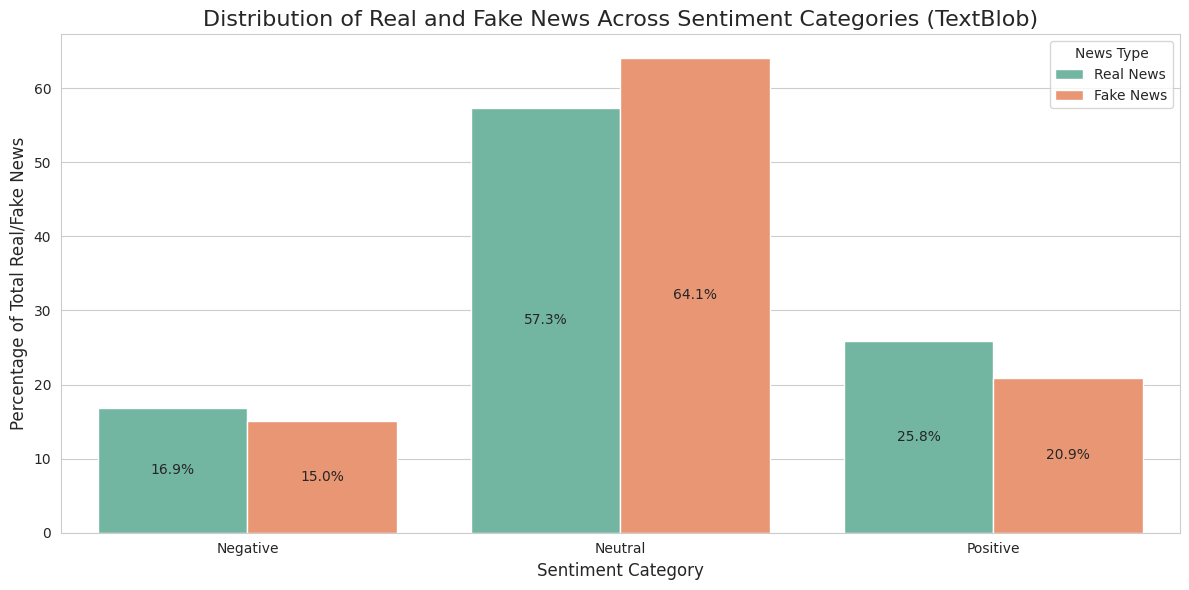

TextBlob Sentiment Distribution:
  textblob_category   real    fake   real_pct   fake_pct
0          Negative  19725   31839  16.871664  15.032720
1           Neutral  66999  135702  57.307205  64.071427
2          Positive  30188   44257  25.821130  20.895854


In [ ]:
# Function to create a grouped bar chart
def create_sentiment_chart(data, title):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("Set2")

    ax = sns.barplot(x='sentiment_category', y='percentage', hue='news_type',
                     data=data, dodge=True,
                     hue_order=['Real News', 'Fake News'],
                     order=['Negative', 'Neutral', 'Positive'])

    plt.title(title, fontsize=16)
    plt.xlabel('Sentiment Category', fontsize=12)
    plt.ylabel('Percentage of Total Real/Fake News', fontsize=12)
    plt.legend(title='News Type', loc='upper right', fontsize=10)

    # Add percentage labels on the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center')

    plt.tight_layout()
    plt.show()

# Prepare data for plotting TextBlob
textblob_plot_data = pd.melt(textblob_dist,
                    id_vars=['textblob_category'],
                    value_vars=['real_pct', 'fake_pct'],
                    var_name='news_type',
                    value_name='percentage')
textblob_plot_data['news_type'] = textblob_plot_data['news_type'].map({'real_pct': 'Real News', 'fake_pct': 'Fake News'})
textblob_plot_data = textblob_plot_data.rename(columns={'textblob_category': 'sentiment_category'})

# Prepare data for plotting VADER
vader_plot_data = pd.melt(vader_dist,
                    id_vars=['vader_category'],
                    value_vars=['real_pct', 'fake_pct'],
                    var_name='news_type',
                    value_name='percentage')
vader_plot_data['news_type'] = vader_plot_data['news_type'].map({'real_pct': 'Real News', 'fake_pct': 'Fake News'})
vader_plot_data = vader_plot_data.rename(columns={'vader_category': 'sentiment_category'})

# Create the TextBlob chart
create_sentiment_chart(textblob_plot_data, 'Distribution of Real and Fake News Across Sentiment Categories (TextBlob)')

# Print the exact percentages and counts
print("TextBlob Sentiment Distribution:")
print(textblob_dist[['textblob_category', 'real', 'fake', 'real_pct', 'fake_pct']])


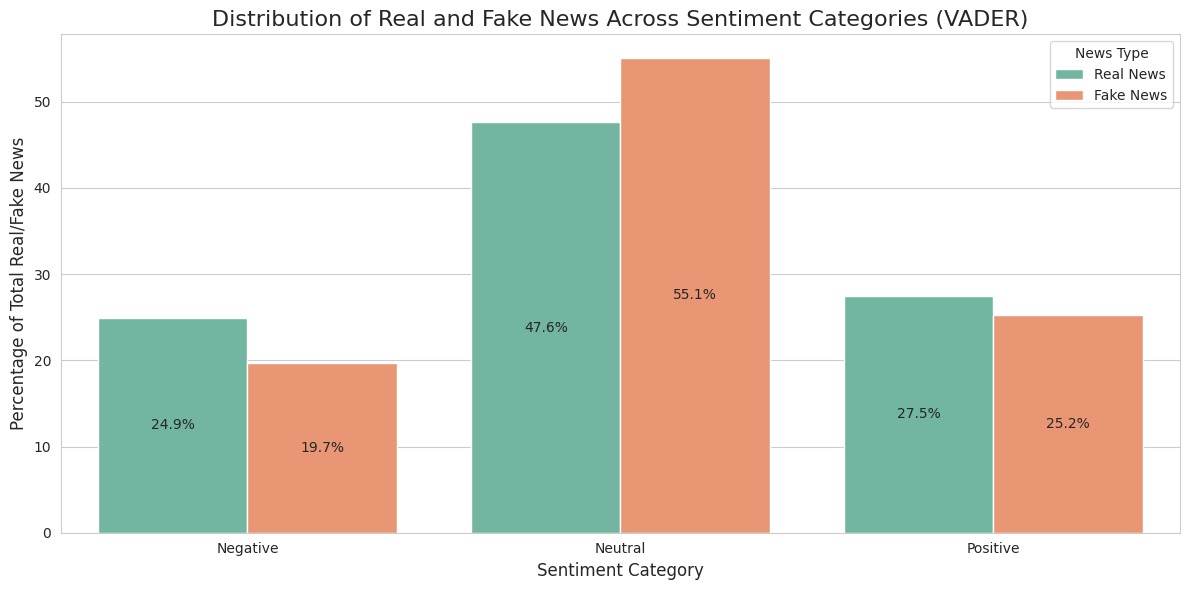


VADER Sentiment Distribution:
  vader_category   real    fake   real_pct   fake_pct
0       Negative  29142   41800  24.926440  19.735786
1        Neutral  55631  116601  47.583653  55.052928
2       Positive  32139   53397  27.489907  25.211286


In [ ]:
# Create the VADER chart
create_sentiment_chart(vader_plot_data, 'Distribution of Real and Fake News Across Sentiment Categories (VADER)')
print("\nVADER Sentiment Distribution:")
print(vader_dist[['vader_category', 'real', 'fake', 'real_pct', 'fake_pct']])

In [36]:
print(f"\nTotal Real News: {total_real}")
print(f"\nTotal Fake News: {total_fake}")


Total Real News: 116912

Total Fake News: 211798


## Bi-LSTM Model

In [37]:
df = df[['title', 'domain', 'num_comments', 'score', 'upvote_ratio', 'sentiment_score', 'emotion_group', 'real', 'fake']]
df.head()

,title,domain,num_comments,score,upvote_ratio,sentiment_score,emotion_group,real,fake
0,walgreens offbrand mucinex engraved letter muc...,i.imgur.com,2.0,12,0.84,0.0000,0.5,0,1
1,concerned sink tiny hat,i.redd.it,2.0,119,0.99,0.0000,0.5,1,0
2,psbattle puppy taking view,i.imgur.com,26.0,250,0.95,0.0000,0.5,0,1
3,found face sheet music,i.redd.it,2.0,13,0.84,0.0000,0.0,1,0
4,bride groom exchange vow fatal shooting wedding,independent.ie,7.0,6,0.64,-0.5423,0.5,0,1


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Hyperparameters
max_words = 10000
max_len = 300
embedding_dim = 300
lstm_units = 128
dropout_rate = 0.2
l1_reg = 0.0001

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['title'])
X_seq = tokenizer.texts_to_sequences(df['title'])
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

# Prepare meta features
X_meta = df[['emotion_group', 'sentiment_score']].values

# Prepare target variable
y = df['fake'].values

# Split the data
X_train_text, X_test_text, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    X_pad, X_meta, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Load GloVe embeddings
print("Loading GloVe embeddings...")
embeddings_index = {}
with open('/content/drive/MyDrive/Colab Notebooks/FYP/glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Creating embedding matrix...")
embedding_matrix = np.zeros((max_words, embedding_dim))
words_not_found = []

for word, i in tokenizer.word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Check if the embedding vector has the correct dimension
        if len(embedding_vector) != embedding_dim:
            print(f"Warning: Embedding vector for word '{word}' has incorrect dimension: {len(embedding_vector)}")
            continue
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print(f"Number of words not found in GloVe: {len(words_not_found)}")
print(f"Sample of words not found: {words_not_found[:10]}")  # Print first 10 words not found

# Check the shape of the embedding matrix
print(f"Shape of embedding matrix: {embedding_matrix.shape}")

# Check if there are any zero vectors in the embedding matrix
zero_vectors = np.all(embedding_matrix == 0, axis=1)
print(f"Number of zero vectors in embedding matrix: {np.sum(zero_vectors)}")

# Print some statistics about the embedding matrix
print(f"Min value in embedding matrix: {np.min(embedding_matrix)}")
print(f"Max value in embedding matrix: {np.max(embedding_matrix)}")
print(f"Mean value in embedding matrix: {np.mean(embedding_matrix)}")

# Check the first few rows of the embedding matrix
print("First few rows of the embedding matrix:")
print(embedding_matrix[:5])

# Proceed with model creation only if the embedding matrix is valid
if np.sum(zero_vectors) < max_words:
    # Your model creation code here
    print("Embedding matrix created successfully. Proceeding with model creation.")
else:
    print("Error: All vectors in the embedding matrix are zero. Please check your GloVe file and tokenizer.")

Loading GloVe embeddings...


<ipython-input-65-e206155e1fd7>:7: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coefs = np.fromstring(coefs, "f", sep=" ")


Creating embedding matrix...
Number of words not found in GloVe: 98
Sample of words not found: ['<OOV>', 'psbattle', 'rpics', 'rfunny', 'rmildlyinteresting', 'colorised', 'jongun', 'rwtf', 'brexit', 'rperfecttiming']
Shape of embedding matrix: (10000, 300)
Number of zero vectors in embedding matrix: 101
Min value in embedding matrix: -4.209499835968018
Max value in embedding matrix: 3.9482998847961426
Mean value in embedding matrix: -0.000901528224917385
First few rows of the embedding matrix:
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.18416999  0.055115   -0.36952999 ... -0.23807999  0.37132001
   0.36197001]
 [-0.019463   -0.18862    -0.33833    ... -0.05039     0.35910001
   0.45368999]]
Embedding matrix created successfully. Proceeding with model creation.


In [ ]:
# Building the model
print("Building the model...")
nlp_input = Input(shape=(max_len,), name='nlp_input')
embedding = Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(nlp_input)
bilstm = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))(embedding)
bilstm = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))(bilstm)

meta_input = Input(shape=(2,), name='meta_input')

concatenated = Concatenate()([bilstm, meta_input])

dense = Dense(64, activation='relu', kernel_regularizer=l1(l1_reg))(concatenated)
dense = Dropout(dropout_rate)(dense)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[nlp_input, meta_input], outputs=output)

Building the model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),])

# Model summary
model.summary()

# Train the model
print("Training the model...")
history_bilstm = model.fit(
    [X_train_text, X_train_meta], y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=32
)

# Predict probabilities
y_pred_proba = model.predict([X_test_text, X_test_meta])
y_pred_classes = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate various metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ nlp_input (InputLayer)    │ (None, 300)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 300, 300)       │      3,000,000 │ nlp_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 300, 256)       │        439,296 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 256)            │        394,240 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_input (InputLayer)   │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 258)            │              0 │ bidirectional_1[0][0], │
│ (Concatenate)             │                        │                │ meta_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │         16,576 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,850,177 (14.69 MB)

 Trainable params: 850,177 (3.24 MB)

 Non-trainable params: 3,000,000 (11.44 MB)

Training the model...
Epoch 1/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 4770s 644ms/step - AUC: 0.7624 - loss: 0.6310 - precision_3: 0.7312 - recall_3: 0.9320 - val_AUC: 0.8385 - val_loss: 0.5290 - val_precision_3: 0.7790 - val_recall_3: 0.9263
Epoch 2/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 5041s 674ms/step - AUC: 0.8305 - loss: 0.5283 - precision_3: 0.7919 - recall_3: 0.8983 - val_AUC: 0.8546 - val_loss: 0.4912 - val_precision_3: 0.8013 - val_recall_3: 0.9101
Epoch 3/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 4968s 672ms/step - AUC: 0.8460 - loss: 0.4966 - precision_3: 0.8036 - recall_3: 0.8962 - val_AUC: 0.8650 - val_loss: 0.4687 - val_precision_3: 0.8128 - val_recall_3: 0.8992
Epoch 4/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 4935s 667ms/step - AUC: 0.8548 - loss: 0.4777 - precision_3: 0.8104 - recall_3: 0.8950 - val_AUC: 0.8742 - val_loss: 0.4497 - val_precision_3: 0.8205 - val_recall_3: 0.8993
Epoch 5/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 4913s 664ms/step - AUC: 0.8631 - loss: 0.4612 - precision_3: 0.8169 - recall_3: 0

NameError: name 'precision_score' is not defined

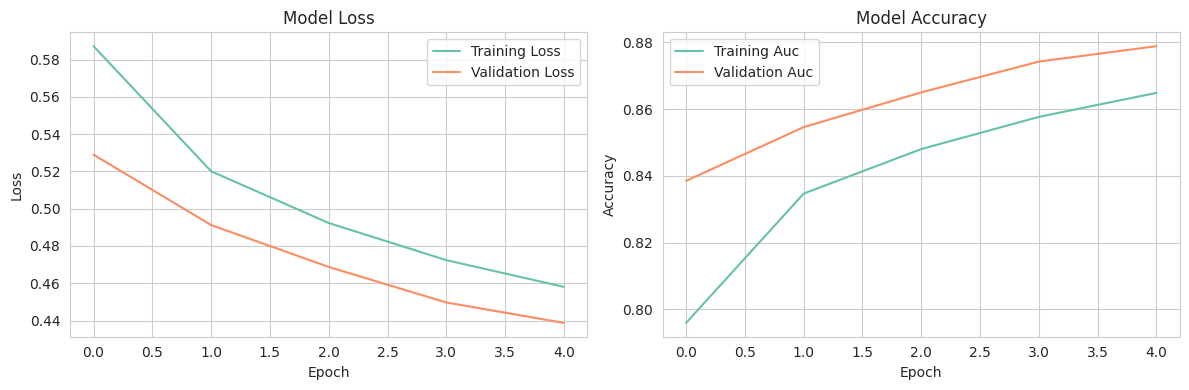

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bilstm.history['AUC'], label='Training Auc')
plt.plot(history_bilstm.history['val_AUC'], label='Validation Auc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## BERT + Bi-LSTM Model

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import shuffle

# Prepare features and target
X_text = df['title'].values
X_meta = df[['emotion_group', 'sentiment_score']].values
y = df['fake'].values

# Train-test split
X_train_text, X_test_text, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    X_text, X_meta, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train_text)}, Test samples: {len(X_test_text)}")

# URLs for the BERT model and preprocessor
bert_model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
preprocess_model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

class BERTBiLSTMClassifier(tf.keras.Model):
    def __init__(self, bert_model_url, preprocess_model_url):
        super(BERTBiLSTMClassifier, self).__init__()

        self.preprocessor = hub.KerasLayer(preprocess_model_url)
        self.bert = hub.KerasLayer(bert_model_url, trainable=True)

        # Bi-LSTM layers
        self.bilstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))
        self.bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))

        # Dropout layers
        self.dropout1 = tf.keras.layers.Dropout(0.2)
        self.dropout2 = tf.keras.layers.Dropout(0.2)

        # Dense layers
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        text_input, meta_input = inputs

        # Preprocess text and get BERT embeddings
        preprocessed_text = self.preprocessor(text_input)
        bert_outputs = self.bert(preprocessed_text)
        sequence_output = bert_outputs['sequence_output']

        # Bi-LSTM layers
        x = self.bilstm1(sequence_output)
        x = self.dropout1(x)
        x = self.bilstm2(x)
        x = self.dropout2(x)

        # Concatenate with meta features
        x = tf.keras.layers.Concatenate()([x, meta_input])

        # Dense layers
        x = self.dense1(x)
        x = self.dense2(x)
        return self.output_layer(x)

# Create custom F1 Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

print("Creating and compiling the model...")
# Create the model
model = BERTBiLSTMClassifier(bert_model_url, preprocess_model_url)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()])

# Define input shapes for summary
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
meta_input = tf.keras.layers.Input(shape=(2,), name='meta')

# Build the model
model.build(input_shape=[(None,), (None, 2)])

# Print model summary
model.summary()

print("Training the model...")
# Train the model
history_bert = model.fit(
    x=[X_train_text, X_train_meta],
    y=y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=32
)


Training samples: 262968, Test samples: 65742
Creating and compiling the model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'bert_bi_lstm_classifier', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "bert_bi_lstm_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 2943s 396ms/step - AUC: 0.8334 - f1_score: 0.8362 - loss: 0.4609 - precision: 0.7852 - recall: 0.8963 - val_AUC: 0.8937 - val_f1_score: 0.8596 - val_loss: 0.3861 - val_precision: 0.8483 - val_recall: 0.8713
Epoch 2/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 2928s 396ms/step - AUC: 0.9003 - f1_score: 0.8691 - loss: 0.3714 - precision: 0.8453 - recall: 0.8944 - val_AUC: 0.9023 - val_f1_score: 0.8692 - val_loss: 0.3711 - val_precision: 0.8401 - val_recall: 0.9005
Epoch 3/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 2923s 395ms/step - AUC: 0.9111 - f1_score: 0.8757 - loss: 0.3532 - precision: 0.8552 - recall: 0.8972 - val_AUC: 0.9047 - val_f1_score: 0.8695 - val_loss: 0.3682 - val_precision: 0.8534 - val_recall: 0.8861
Epoch 4/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 2927s 396ms/step - AUC: 0.9188 - f1_score: 0.8824 - loss: 0.3380 - precision: 0.8631 - recall: 0.9025 - val_AUC: 0.9090 - val_f1_score: 0.8739 - val_loss: 0.3626 - val_precision: 0.8442 - val_r

In [ ]:
# Predict probabilities
y_pred_proba = model.predict([X_test_text, X_test_meta])
y_pred_classes = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate various metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

2055/2055 ━━━━━━━━━━━━━━━━━━━━ 682s 332ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76     23441
           1       0.86      0.89      0.88     42301

    accuracy                           0.84     65742
   macro avg       0.83      0.81      0.82     65742
weighted avg       0.84      0.84      0.84     65742



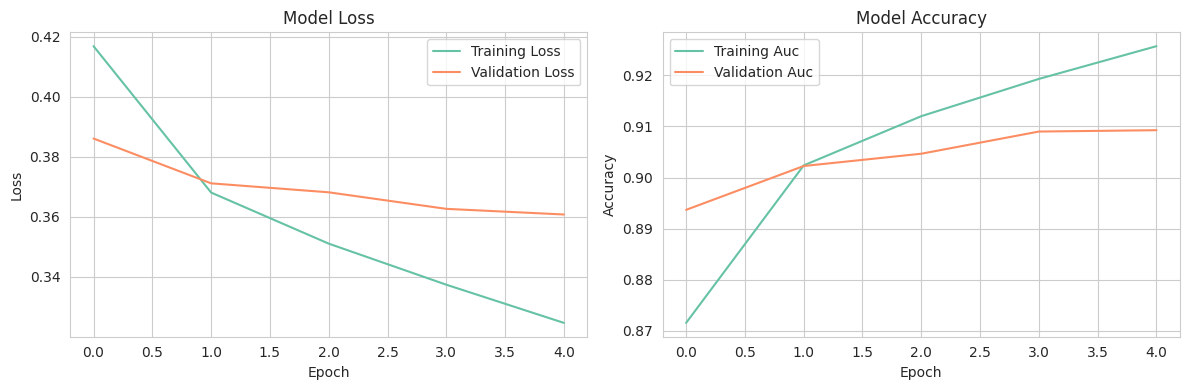

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_bert.history['loss'], label='Training Loss')
plt.plot(history_bert.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bert.history['AUC'], label='Training Auc')
plt.plot(history_bert.history['val_AUC'], label='Validation Auc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Improved BERT + Bi-LSTM Model

In [38]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split

# Prepare features and target
X_text = df['title'].values
X_meta = df[['emotion_group', 'sentiment_score']].values
y = df['fake'].values

# Train-test split
X_train_text, X_test_text, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    X_text, X_meta, y, test_size=0.2, random_state=42
)

# URLs for the BERT model and preprocessor (unchanged)
bert_model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
preprocess_model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"


class ImprovedBERTBiLSTMClassifier(tf.keras.Model):
    def __init__(self, bert_model_url, preprocess_model_url):
        super(ImprovedBERTBiLSTMClassifier, self).__init__()

        self.preprocessor = hub.KerasLayer(preprocess_model_url)
        self.bert = hub.KerasLayer(bert_model_url, trainable=True)

        # Bi-LSTM layers with L2 regularization
        self.bilstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        self.bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, kernel_regularizer=tf.keras.regularizers.l2(0.01)))

        # Increased dropout rates
        self.dropout1 = tf.keras.layers.Dropout(0.3)
        self.dropout2 = tf.keras.layers.Dropout(0.3)

        # Dense layers with L2 regularization
        self.dense1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dense2 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        text_input, meta_input = inputs

        preprocessed_text = self.preprocessor(text_input)
        bert_outputs = self.bert(preprocessed_text)
        sequence_output = bert_outputs['sequence_output']

        x = self.bilstm1(sequence_output)
        x = self.dropout1(x)
        x = self.bilstm2(x)
        x = self.dropout2(x)

        x = tf.keras.layers.Concatenate()([x, meta_input])

        x = self.dense1(x)
        x = self.dense2(x)
        return self.output_layer(x)

# Custom F1 Score metric (unchanged)
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Create and compile the improved model
improved_model = ImprovedBERTBiLSTMClassifier(bert_model_url, preprocess_model_url)

improved_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()]
)

# Assuming input shapes for text and meta features
sample_text_input = tf.constant(X_train_text[:2])
sample_meta_input = tf.constant(X_train_meta[:2])

# Call the model with the inputs to build it
improved_model([sample_text_input, sample_meta_input])

# Now we can print the model summary
improved_model.summary()

Model: "improved_bert_bi_lstm_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (2, 128, 256)               │         918,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (2, 256)                    │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (2, 128, 256)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (2, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (2, 128)                    │          33,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (2, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (2, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,354,241 (5.17 MB)

 Trainable params: 1,354,241 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Train the improved model
history_improved = improved_model.fit(
    x=[X_train_text, X_train_meta],
    y=y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=32
)

Epoch 1/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 2988s 402ms/step - AUC: 0.7966 - f1_score: 0.8250 - loss: 13.7019 - precision: 0.7518 - recall: 0.9174 - val_AUC: 0.8732 - val_f1_score: 0.8429 - val_loss: 2.9584 - val_precision: 0.8375 - val_recall: 0.8484
Epoch 2/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 2971s 402ms/step - AUC: 0.8772 - f1_score: 0.8559 - loss: 2.3668 - precision: 0.8235 - recall: 0.8909 - val_AUC: 0.8853 - val_f1_score: 0.8558 - val_loss: 1.4821 - val_precision: 0.8356 - val_recall: 0.8770
Epoch 3/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 2971s 402ms/step - AUC: 0.8867 - f1_score: 0.8608 - loss: 1.3635 - precision: 0.8312 - recall: 0.8925 - val_AUC: 0.8919 - val_f1_score: 0.8503 - val_loss: 1.1190 - val_precision: 0.8638 - val_recall: 0.8372
Epoch 4/5
7396/7396 ━━━━━━━━━━━━━━━━━━━━ 2971s 402ms/step - AUC: 0.8944 - f1_score: 0.8658 - loss: 1.0522 - precision: 0.8377 - recall: 0.8959 - val_AUC: 0.8961 - val_f1_score: 0.8576 - val_loss: 0.9243 - val_precision: 0.8541 - val_recall: 0.8612
Epoch 5

In [41]:
# Evaluate the model
test_results = improved_model.evaluate([X_test_text, X_test_meta], y_test)
print(f"Test results: {dict(zip(improved_model.metrics_names, test_results))}")

# Make predictions
y_pred = improved_model.predict([X_test_text, X_test_meta])

# Print classification report and ROC AUC score
from sklearn.metrics import classification_report, roc_auc_score
print("\nClassification Report:")
print(classification_report(y_test, (y_pred > 0.5).astype(int)))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred)}")

2055/2055 ━━━━━━━━━━━━━━━━━━━━ 707s 344ms/step - AUC: 0.9041 - f1_score: 0.8689 - loss: 0.7930 - precision: 0.8474 - recall: 0.8915
Test results: {'loss': 0.7956698536872864, 'compile_metrics': 0.9020439386367798}
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 686s 333ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.75     23441
           1       0.85      0.89      0.87     42301

    accuracy                           0.83     65742
   macro avg       0.82      0.80      0.81     65742
weighted avg       0.82      0.83      0.82     65742


ROC AUC Score: 0.9020776006911191


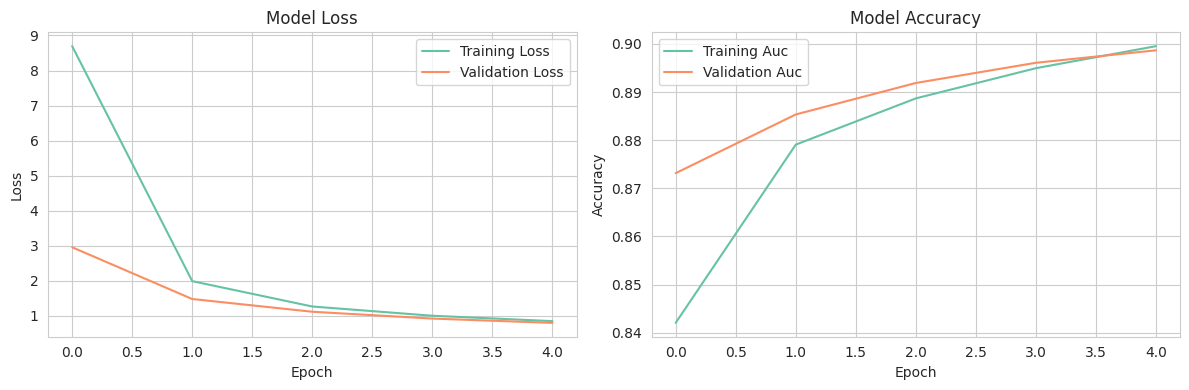

In [40]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_improved.history['loss'], label='Training Loss')
plt.plot(history_improved.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_improved.history['AUC'], label='Training Auc')
plt.plot(history_improved.history['val_AUC'], label='Validation Auc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()